In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


1.Import necessary modules and load the dataset of IEEE-CIS Fraud Detection

In [ ]:
import numpy as np                   # For numerical operations
import pandas as pd                  # For data manipulation and analysis
import seaborn as sns                # For data visualization
import matplotlib.pyplot as plt      # For creating static, animated, and interactive visualizations
from numpy.linalg import inv         # For matrix inversion
%matplotlib inline                   # To display plots in the Jupyter Notebook

# Import machine learning tools from Scikit-learn library
from sklearn.model_selection import train_test_split    # For splitting data into training and testing sets
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # For data preprocessing
import category_encoders as ce        # For encoding categorical features
from sklearn.metrics import r2_score  # For evaluating regression models
from sklearn.svm import LinearSVC, SVC  # For support vector machine classifiers
import random  # For generating random numbers

# Import evaluation metric from Scikit-learn library
from sklearn.metrics import accuracy_score  # For evaluating classification models

# Import utility for applying different preprocessing techniques to different subsets of the features
from sklearn.compose import make_column_transformer

# Import oversampling technique from imbalanced-learn library
from imblearn.over_sampling import SMOTE  # For handling imbalanced datasets

# Import PCA from Scikit-learn library for dimensionality reduction
from sklearn.decomposition import PCA


In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/IEEE-CIS/

Mounted at /content/drive
/content/drive/MyDrive/IEEE-CIS


In [ ]:
# load provided datasets
train_transaction = pd.read_csv('train_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')

# combine datasets as needed
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

2.Filters the columns in the 'train' DataFrame based on the percentage of missing values.

In [ ]:
# The dataset are sparse, only consider the features with less than 30% missing data

valid_cols = pd.DataFrame(train.isnull().sum()/len(train)*100 < 30) # Identify columns with missing values percentage less than 30%

valid_cols = valid_cols[valid_cols[0] == True] # Keep only columns with less than 30% missing values

train = train[list(valid_cols.index)] # Update the 'train' DataFrame to include only valid columns

3.Seperate categorical variables

In [ ]:
# Seperate categorical variables
train = train.astype({'ProductCD': 'category',
                   'card1': 'category','card2': 'category','card3': 'category','card4': 'category','card5': 'category','card6': 'category',
                   'addr1': 'category','addr2': 'category',
                   'P_emaildomain': 'category',
                   'M6': 'category'})

4.Fill missing values in numerical columns

In [ ]:
# Fill missing values in numerical columns
num_cols = train.select_dtypes(include=np.number).columns.tolist() # Identify numerical columns in the 'train' DataFrame

# Loop through the numerical columns
for column in num_cols:
    train[column].fillna(train[column].median(), inplace=True) # Fill missing values with the median value of the respective column

5.Seperate X and Y

In [ ]:
# Prepare the feature matrix (train_X) and target vector (train_Y)
train_X = train.drop(columns=['isFraud']) 
train_Y = train['isFraud']

# Split the data into development and test sets using stratified sampling
X_dev, X_test, y_dev, y_test = train_test_split(train_X, train_Y, test_size=0.2, stratify=train_Y, random_state=42)

6.Remoove highly correlated numerical features from the development and test DataFrames 

In [ ]:
# Compute the absolute correlation matrix for numerical features in X_dev
corr_matrix = X_dev.corr().abs()

# Create an upper triangular matrix from the correlation matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype('bool'))

# Identify columns with a correlation value of 0.9 or higher
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= 0.9)]

# Drop the highly correlated columns from both X_dev and X_test DataFrames
X_dev = X_dev.drop(to_drop, axis=1)
X_test = X_test.drop(to_drop, axis=1)

<ipython-input-14-f57138035e0b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = X_dev.corr().abs()


7.preprocess the development and test DataFrames

In [ ]:
# Identify different types of columns for preprocessing
num_cols = X_dev.select_dtypes(include=np.number).columns.drop(['TransactionID']).tolist()
te_cols = ['TransactionID','card1', 'card2', 'addr1', 'card5', 'card3', 'addr2', 'P_emaildomain']
cat_cols = X_dev.select_dtypes(exclude=np.number).columns.drop(['card1', 'card2', 'addr1', 'card5', 'card3', 'addr2', 'P_emaildomain']).tolist()

# Define the features for each preprocessing method
ohe_features = cat_cols
num_features = num_cols
te_features = te_cols

# Create a column transformer to preprocess different types of columns
preprocess = make_column_transformer((StandardScaler(), num_features), (OneHotEncoder(handle_unknown='ignore'), ohe_features), (ce.TargetEncoder(return_df=True), te_features))

# Fit the column transformer to the development data
preprocess.fit(X_dev, y_dev)

# Transform the development and test DataFrames using the fitted column transformer
X_dev = preprocess.transform(X_dev)
X_test = preprocess.transform(X_test)

In [ ]:
# Instantiate a SMOTE object for handling class imbalance
smote = SMOTE(random_state=42)

# Fit and apply SMOTE on the development data to balance classes
X_dev, y_dev = smote.fit_resample(X_dev, y_dev)

8.Model tracking on Logistic Regreesion and Hist Gradient Boosting

In [ ]:
import optuna
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, average_precision_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression

# Define objective functions for logistic regression and histogram-based gradient boosting optimization

# Objective function for logistic regression
def logistic_objective(trial):

    # Suggest hyperparameters for the logistic regression model
    C = trial.suggest_float("C", 1e-5, 1e1, log=True)
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])
    logistic = LogisticRegression(solver='lbfgs', C=C, class_weight=class_weight, max_iter=1000, random_state=42, n_jobs=-1)

    # Train and evaluate the logistic regression model using stratified K-fold cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(logistic, X_dev, y_dev, cv=cv, scoring='roc_auc', n_jobs=-1)
    
    return np.mean(auc_scores)

# Objective function for histogram-based gradient boosting
def hist_gb_objective(trial):

    # Suggest hyperparameters for the histogram-based gradient boosting model
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1, log=True)
    max_iter = trial.suggest_int("max_iter", 50, 200)
    max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 15, 127)
    max_depth = trial.suggest_int("max_depth", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    l2_regularization = trial.suggest_float("l2_regularization", 0, 10)

    # Train and evaluate the histogram-based gradient boosting model using stratified K-fold cross-validation
    hist_gb = HistGradientBoostingClassifier(learning_rate=learning_rate, max_iter=max_iter, max_leaf_nodes=max_leaf_nodes, max_depth=max_depth, min_samples_leaf=min_samples_leaf, l2_regularization=l2_regularization, random_state=42)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(hist_gb, X_dev, y_dev, cv=cv, scoring='roc_auc', n_jobs=-1)

    return np.mean(auc_scores)

# Optimize hyperparameters for logistic regression and histogram gradient boosting models
logistic_study = optuna.create_study(direction='maximize')
logistic_study.optimize(logistic_objective, n_trials=10)  # Increase the number of trials to 10
hist_gb_study = optuna.create_study(direction='maximize')
hist_gb_study.optimize(hist_gb_objective, n_trials=10)  # Increase the number of trials to 10

# Get the best hyperparameters for both models
best_logistic_params = logistic_study.best_params
best_hist_gb_params = hist_gb_study.best_params

# Train the models with the best hyperparameters
logistic_clf = LogisticRegression(**best_logistic_params, solver='lbfgs', max_iter=1000, random_state=42, n_jobs=-1)
hist_gb_clf = HistGradientBoostingClassifier(**best_hist_gb_params, random_state=42)

# Fit the models on the development data
logistic_clf.fit(X_dev, y_dev)
hist_gb_clf.fit(X_dev, y_dev)

# Make predictions on the test data
logistic_pred = logistic_clf.predict(X_test)
hist_gb_pred = hist_gb_clf.predict(X_test)

# Calculate various performance metrics for the logistic regression and histogram-based gradient boosting models
logistic_auc = roc_auc_score(y_test, logistic_pred)
hist_gb_auc = roc_auc_score(y_test, hist_gb_pred)
logistic_precision = precision_score(y_test, logistic_pred)
hist_gb_precision = precision_score(y_test, hist_gb_pred)


logistic_recall = recall_score(y_test, logistic_pred)
hist_gb_recall = recall_score(y_test, hist_gb_pred)

logistic_avg_precision = average_precision_score(y_test, logistic_pred)
hist_gb_avg_precision = average_precision_score(y_test, hist_gb_pred)

# Print evaluation metrics
print("logistic Classifier:")
print(f"AUC: {logistic_auc:.4f}")
print(f"Precision: {logistic_precision:.4f}")
print(f"Recall: {logistic_recall:.4f}")
print(f"Average Precision-Recall: {logistic_avg_precision:.4f}")

print("\nHist Gradient Boosting Classifier:")
print(f"AUC: {hist_gb_auc:.4f}")
print(f"Precision: {hist_gb_precision:.4f}")
print(f"Recall: {hist_gb_recall:.4f}")
print(f"Average Precision-Recall: {hist_gb_avg_precision:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(
[I 2023-04-29 23:47:54,061] A new study created in memory with name: no-name-b113fddc-4afe-4a17-8c8c-8b4b28da2b25
[I 2023-04-29 23:48:11,924] Trial 0 finished with value: 0.5225767475792028 and parameters: {'C': 0.0001119690581683181, 'class_weight': None}. Best is trial 0 with value: 0.5225767475792028.
[I 2023-04-29 23:48:28,030] Trial 1 finished with value: 0.5225767475792028 and parameters: {'C': 0.01168689954113468, 'class_weight': None}. Best is trial 0 with value: 0.5225767475792028.
[I 2023-04-29 23:48:41,452] Trial 2 finished with value: 0.5225767475792028 and parameters: {'C': 0.009410901260417869, 'class_weight': None}. Best is trial 0 

logistic Classifier:
AUC: 0.5000
Precision: 0.0350
Recall: 1.0000
Average Precision-Recall: 0.0350

Hist Gradient Boosting Classifier:
AUC: 0.7306
Precision: 0.8016
Recall: 0.4653
Average Precision-Recall: 0.3917


9.Print the best Hyperparameters for both models

In [ ]:
print("Best Hyperparameters: ", logistic_study.best_params)
print("Best Hyperparameters: ", hist_gb_study.best_params)

Best Hyperparameters:  {'C': 0.0001119690581683181, 'class_weight': None}
Best Hyperparameters:  {'learning_rate': 0.16884155865294526, 'max_iter': 166, 'max_leaf_nodes': 39, 'max_depth': 5, 'min_samples_leaf': 13, 'l2_regularization': 9.24448285366364}


10.Plot the Precision-Recall curve

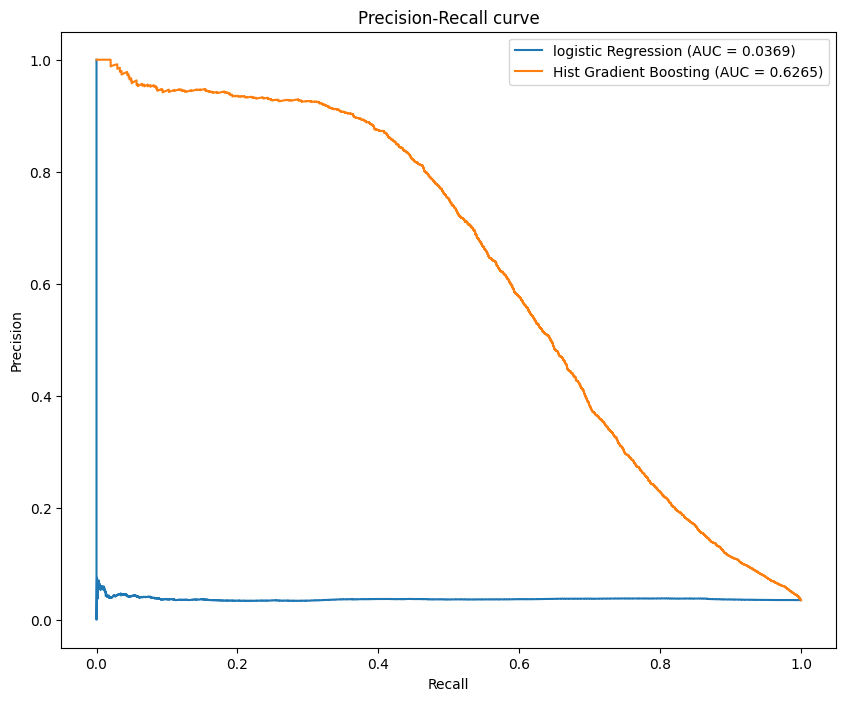

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Compute Precision-Recall curve
logistic_prob = logistic_clf.predict_proba(X_test)[:, 1]
hist_gb_prob = hist_gb_clf.predict_proba(X_test)[:, 1]

logistic_precision, logistic_recall, _ = precision_recall_curve(y_test, logistic_prob)
hist_gb_precision, hist_gb_recall, _ = precision_recall_curve(y_test, hist_gb_prob)

# Compute the AUC of the Precision-Recall curve
logistic_pr_auc = auc(logistic_recall, logistic_precision)
hist_gb_pr_auc = auc(hist_gb_recall, hist_gb_precision)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 8))
plt.plot(logistic_recall, logistic_precision, label=f'logistic Regression (AUC = {logistic_pr_auc:.4f})')
plt.plot(hist_gb_recall, hist_gb_precision, label=f'Hist Gradient Boosting (AUC = {hist_gb_pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='best')
plt.show()

11.Plot the ROC curves for both models

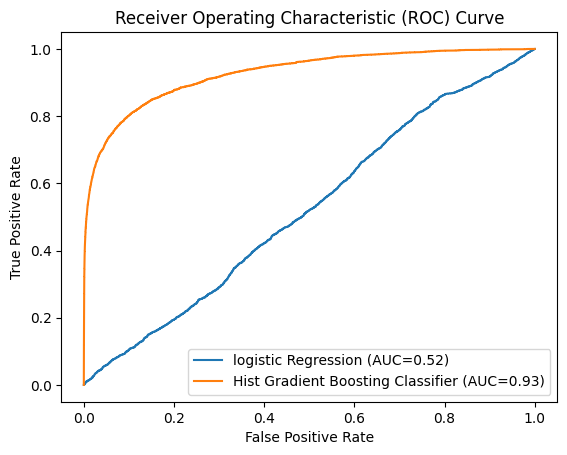

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the predicted probabilities for the logistic regression and histogram-based gradient boosting classifiers
y_pred_proba_logistic = logistic_clf.predict_proba(X_test)[:, 1]
y_pred_proba_hist = hist_gb_clf.predict_proba(X_test)[:, 1]

# Compute the false positive rate (FPR), true positive rate (TPR), and AUC for both models
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y_test, y_pred_proba_logistic, pos_label=1)
fpr_hist, tpr_hist, thresholds_hist = roc_curve(y_test, y_pred_proba_hist, pos_label=1)
auc_logistic = auc(fpr_logistic, tpr_logistic)
auc_hist = auc(fpr_hist, tpr_hist)

# Plot the ROC curves for both models
plt.plot(fpr_logistic, tpr_logistic, label=f'logistic Regression (AUC={auc_logistic:.2f})')
plt.plot(fpr_hist, tpr_hist, label=f'Hist Gradient Boosting Classifier (AUC={auc_hist:.2f})')

# Set the plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Add a legend and display the plot
plt.legend()
plt.show()

12.Print the classification reports for both logistic regression and histogram-based gradient boosting classifiers

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, logistic_pred))
print(classification_report(y_test, hist_gb_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    113975
           1       0.03      1.00      0.07      4133

    accuracy                           0.03    118108
   macro avg       0.02      0.50      0.03    118108
weighted avg       0.00      0.03      0.00    118108

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.80      0.47      0.59      4133

    accuracy                           0.98    118108
   macro avg       0.89      0.73      0.79    118108
weighted avg       0.97      0.98      0.97    118108



In [ ]:
import numpy as np

np.save('fpr_logistic.npy', fpr_logistic)
np.save('tpr_logistic.npy', tpr_logistic)
np.save('fpr_hist.npy', fpr_hist)
np.save('tpr_hist.npy', tpr_hist)